In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *

In [5]:
import pretrainedmodels

In [6]:
from fastai.callbacks.hooks import  params_size
def extract_train_information(learner: Learner):
    _, params, trainables, _ = params_size(learner.model)

    total_params = sum(params)
    trainable_ratio = sum([param*train for param, train in zip(params, trainables)]) / total_params * 100

    bs = learner.data.batch_size
    image_size = learner.data.valid_ds[0][0].size
    wd = learner.wd
    lr = max(learner.recorder.lrs)

    summary = "\nTotal params: {:,}".format(total_params)
    summary += f"\nTrainable: {round(trainable_ratio,2)}%"
    summary += f"\nBs: {bs}"
    summary += f"\nwd: {wd}"
    summary += f"\nlr: {lr}"
    summary += f"\nImage: {image_size}\n"

    for tf in learner.data.train_dl.dl.dataset.tfms:
        summary += f"\n {tf}"
    
    return summary

In [7]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [8]:
np.random.seed(42)

In [9]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [10]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

In [11]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

## Split data into train val 

In [12]:
split_handler = SplitByPatient(hem_patients, all_patints)

### Split by regex

In [13]:
train_regex = re.compile(r'(fold_0|fold_1)')
val_regex = re.compile(r'(fold_2)')

hem_train, all_train, hem_val, all_val = split_handler.split_by_regex(train_regex, val_regex)

In [14]:
print('Train Total: {0}'.format(len(hem_train)+len(all_train)))
print('Val Total: {0}'.format(len(hem_val)+len(all_val)))
print("")
print('Hem train: {}'.format(len(hem_train)))
print('All train: {}'.format(len(all_train)))
print('Hem val: {}'.format(len(hem_val)))
print('All val: {}'.format(len(all_val)))

Train Total: 7108
Val Total: 3517

Hem train: 2293
All train: 4815
Hem val: 1060
All val: 2457


In [15]:
pat = re.compile(r'^.*(hem|all).bmp$')

def get_label(fn):
    return pat.search(str(fn)).group(1)

### Use complete image

In [16]:
train = ImageItemList(hem_train + all_train) #optinal scale up classes 
valid = ImageItemList(hem_val + all_val)

In [17]:
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_label)

#### Data augmentation

In [18]:
def _cutout(img, n_holes:int = 5, length:float = 0.05)->Tensor:
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (float): The length (in percent of the image size) of each square patch.
    """
    h = img.size(1)
    w = img.size(2)
    patch_width = int(w * length)
    path_height = int(h * length)

    mask = np.ones((h, w), np.float32)

    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - path_height // 2, 0, h)
        y2 = np.clip(y + path_height // 2, 0, h)
        x1 = np.clip(x - patch_width // 2, 0, w)
        x2 = np.clip(x + patch_width // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    return img * mask
cutout = TfmLighting(_cutout)

In [19]:
xtra_tfms=[cutout(n_holes=5, length=0.2)]#squish(scale=0.66), 
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      #max_lighting=0.15, 
                      #max_zoom=1.5, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

#### Create dataset 

In [20]:
def get_data(bs, size):
    data  = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, 
                                      ds_tfms=tfms, padding_mode='zeros',
                                      resize_method=ResizeMethod.PAD)
    data = data.normalize()
    #data = data.normalize((channel_mean, channel_std))
    return data
    

### Start training 256

In [21]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [22]:
experiment_name = 'dpn98'

In [23]:
def get_cadene_model(pretrained=True, model_name='dpn98'):
    if pretrained:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    else:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000)
    return arch

In [24]:
size = 256
bs = 64 

In [25]:
gc.collect();

In [26]:
learn = create_cnn(get_data(bs, size), get_cadene_model, #cut=-2,
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.4, gamma=0.5),
                   #ps=0.75,
                   #wd=0.01,
                   callback_fns=[ShowGraph, partial(SaveModelCallback, monitor="mcc", mode='max', name='stage1-{}-{}'.format(experiment_name, size))],
                  ).to_fp16().mixup()                

In [27]:
learn.callback_fns

[fastai.basic_train.Recorder,
 fastai.train.ShowGraph,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, monitor='mcc', mode='max', name='stage1-dpn68-256'),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


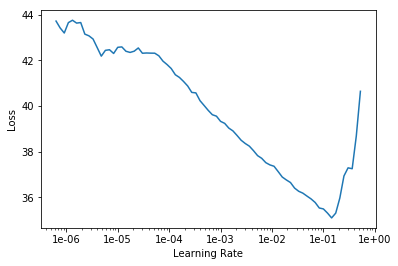

In [45]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.624830,0.622717,0.243105,0.755291,0.415550
2,0.487203,0.420152,0.181973,0.810724,0.546521
3,0.439811,0.389964,0.150697,0.835053,0.632473
4,0.416988,0.509449,0.255331,0.755023,0.506098
5,0.402230,0.555135,0.208416,0.750039,0.487448
6,0.399561,0.421596,0.153540,0.830632,0.626890
7,0.383300,0.371222,0.132215,0.858675,0.677628
8,0.369667,0.401012,0.143020,0.843328,0.654966
9,0.363080,0.359022,0.129656,0.862597,0.682770
10,0.358126,0.364740,0.128519,0.863047,0.686969


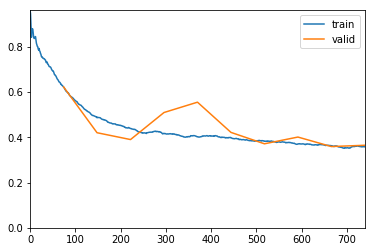


Total params: 61,647,554
Trainable: 4.75%
Bs: 96
wd: 0.01
lr: 0.01
Image: torch.Size([256, 256])

 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.2059572659946034, 'col_pct': 0.02321422546827867, 'padding_mode': 'reflection'}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 3}, do_run=True, is_random=True)
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([ 0.1603,  0.0007, -0.1783,  0.1335]), 'invert': False}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={'degrees': -35.20665129449738}, do_run=False, is_random=True)
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={'row_pct': 0.715457763221008, 'col_pct': 0.05229085361037533, 'scale': 1.0986508867

In [28]:
learn.fit_one_cycle(10, lr) #, pct_start=0.8
print(extract_train_information(learn))

##### And fine-tune the whole model

In [27]:
learn.load("stage1-dpn98-256")

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (7108 items)
[Category hem, Category hem, Category hem, Category hem, Category hem]...
Path: .
x: ImageItemList (7108 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: .;

Valid: LabelList
y: CategoryList (3517 items)
[Category hem, Category hem, Category hem, Category hem, Category hem]...
Path: .
x: ImageItemList (3517 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1_1): InputBlock(
        (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
  

In [28]:
learn.unfreeze()

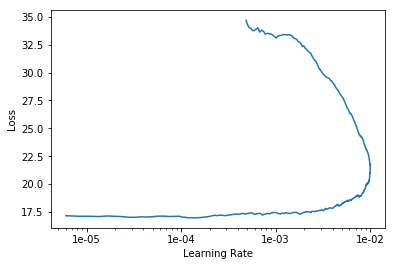

In [29]:
#learn.lr_find()
learn.recorder.plot()

In [29]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.348022,0.361553,0.130793,0.862428,0.678729
2,0.356077,0.367197,0.128519,0.865947,0.684177
3,0.354228,0.358018,0.127950,0.867332,0.685690
4,0.357561,0.351636,0.122263,0.872524,0.700358
5,0.360212,0.361238,0.129372,0.862617,0.683914
6,0.349850,0.346424,0.135058,0.861188,0.668645
7,0.347311,0.347345,0.128234,0.867570,0.685221
8,0.341232,0.354354,0.131931,0.863829,0.675909
9,0.346089,0.343942,0.128803,0.865948,0.683420
10,0.341333,0.343729,0.127097,0.867241,0.687913


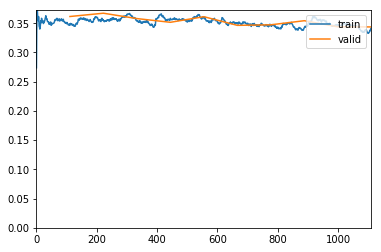


Total params: 61,647,554
Trainable: 100.0%
Bs: 64
wd: 0.01
lr: 0.002
Image: torch.Size([256, 256])

 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.5218106085810359, 'col_pct': 0.650255235786197, 'padding_mode': 'reflection'}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 3}, do_run=True, is_random=True)
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.0278,  0.1157, -0.0614,  0.1029]), 'invert': False}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={'degrees': 75.29502856528694}, do_run=False, is_random=True)
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={'row_pct': 0.6047395591053508, 'col_pct': 0.47045501576051896, 'scale': 1.0944553067

In [32]:
learn.fit_one_cycle(10, slice(1e-5,lr/5))
print(extract_train_information(learn))

### Start training  384

In [27]:
size = 384
bs = 24
learn.freeze()

In [28]:
learn.data = get_data(bs, size)

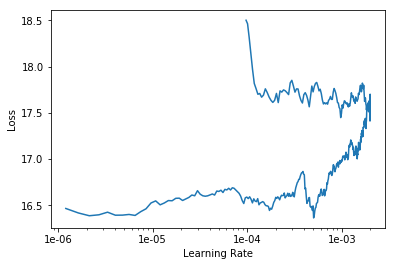

In [34]:
#learn.lr_find()
learn.recorder.plot()

In [35]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.379488,0.376142,0.138470,0.849046,0.666208
2,0.402522,1.075554,0.502417,0.479671,0.276775
3,0.415895,0.477864,0.181689,0.792268,0.554894
4,0.407444,0.665336,0.245095,0.689222,0.371859
5,0.408676,0.434433,0.173443,0.820915,0.570623
6,0.376366,0.470253,0.170600,0.814168,0.574153
7,0.369855,0.444770,0.169463,0.820815,0.576194
8,0.361618,0.330643,0.114871,0.881437,0.719126
9,0.361944,0.360360,0.128803,0.865732,0.683430
10,0.362089,0.354271,0.123685,0.870265,0.697138


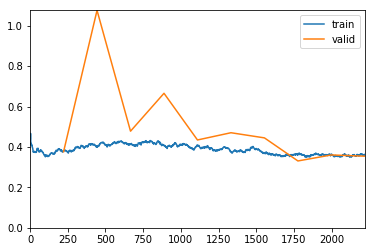

In [36]:
lr = 1e-2
learn.fit_one_cycle(10, lr)

##### And fine-tune the whole model

In [29]:
learn.load("stage1-dpn98-384")

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (7108 items)
[Category hem, Category hem, Category hem, Category hem, Category hem]...
Path: .
x: ImageItemList (7108 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: .;

Valid: LabelList
y: CategoryList (3517 items)
[Category hem, Category hem, Category hem, Category hem, Category hem]...
Path: .
x: ImageItemList (3517 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1_1): InputBlock(
        (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
  

In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


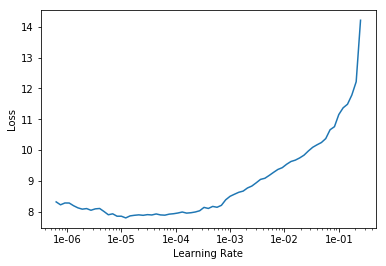

In [38]:
#learn.lr_find()
learn.recorder.plot()

In [32]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.354795,0.354021,0.125675,0.870041,0.691624
2,0.369918,0.382401,0.132784,0.860897,0.673221
3,0.355906,0.399863,0.134774,0.858724,0.668040
4,0.352026,0.415652,0.133068,0.859108,0.673485
5,0.357575,0.337257,0.118567,0.876845,0.709726
6,0.361979,0.344666,0.128234,0.869031,0.686966
7,0.356122,0.361291,0.128803,0.867712,0.684463
8,0.337654,0.362097,0.130793,0.866303,0.680420
9,0.335827,0.366732,0.136196,0.861456,0.668436
10,0.348502,0.349238,0.120842,0.874133,0.703982


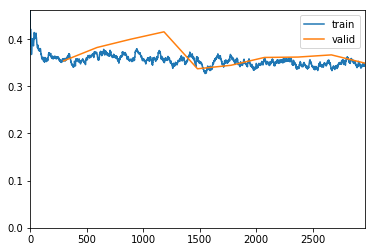

In [35]:
learn.fit_one_cycle(10, slice(1e-5,lr/5))

### Start training  450

In [36]:
size = 450
bs = 24
learn.freeze()

In [37]:
gc.collect();

In [38]:
learn.data = get_data(bs, size)

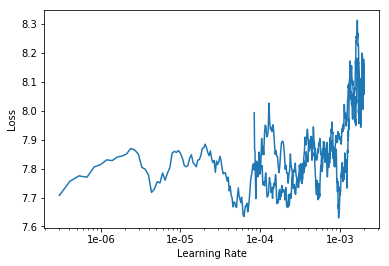

In [44]:
#learn.lr_find()
learn.recorder.plot()

In [39]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.356203,0.449758,0.158942,0.831446,0.604245
2,0.377417,1.162525,0.210407,0.761231,0.460779
3,0.386357,1.087017,0.147853,0.839285,0.638491
4,0.405178,0.480638,0.155246,0.829888,0.619656
5,0.378046,0.360516,0.131362,0.857435,0.684741
6,0.369580,0.725349,0.224623,0.782171,0.517656
7,0.377406,0.342115,0.117714,0.878181,0.711863
8,0.358001,0.366605,0.130509,0.863508,0.679089
9,0.347469,0.368092,0.126244,0.868320,0.690069
10,0.366287,0.362689,0.122548,0.869441,0.703115


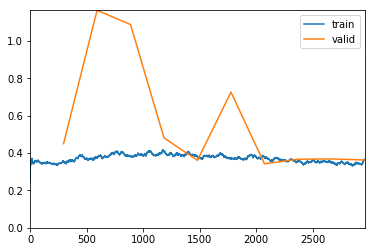

In [40]:
lr = 1e-2
learn.fit_one_cycle(10, lr)

##### And fine-tune the whole model

In [41]:
learn.unfreeze()

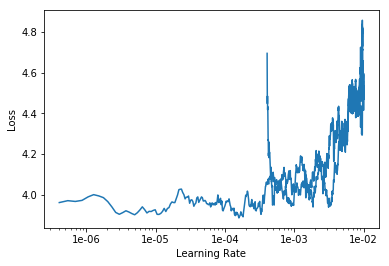

In [48]:
#learn.lr_find()
learn.recorder.plot()

In [42]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.354135,0.379329,0.136764,0.861148,0.667713
2,0.353710,0.390031,0.132499,0.864605,0.676268
3,0.356126,0.385837,0.170031,0.831095,0.602146
4,0.349400,0.966717,0.154393,0.844813,0.629893
5,0.355967,0.338418,0.116577,0.878354,0.715147
6,0.354117,0.368536,0.133921,0.862749,0.672055
7,0.347601,0.417107,0.148422,0.848643,0.637456
8,0.332973,0.365052,0.130509,0.865068,0.679347
9,0.355524,0.359376,0.122548,0.871940,0.699764
10,0.340245,0.471380,0.127666,0.867806,0.686480


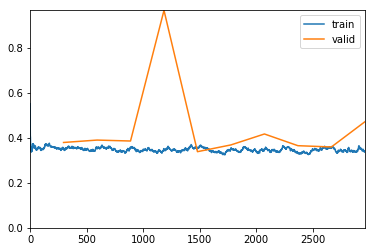

In [43]:
lr = 1e-4
learn.fit_one_cycle(10, slice(1e-5,lr/5))

## Results

In [51]:
learn.loss_func = data.loss_func
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

NameError: name 'data' is not defined

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

In [ ]:
int(interp.confusion_matrix().flatten()[[1, 2]].sum())